In [19]:
import numpy as np 
import pandas as pd
import spacy 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [22]:
data = pd.read_csv('../data/combined_news.csv')
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 44897
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
dtypes: object(4)
memory usage: 1.7+ MB


In [ ]:
sns.countplot(data['label'])

C:\Users\Hussein\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    44898.000000
mean       415.760412
std        361.648003
min          1.000000
25%        208.000000
50%        371.000000
75%        525.000000
max       8436.000000
Name: length, dtype: float64

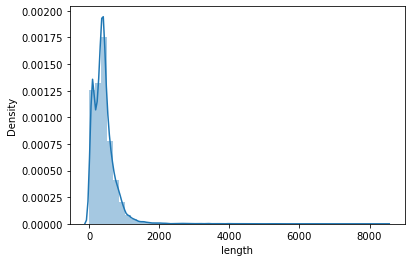

In [23]:
data['length'] = data['text'].apply(lambda x: len(x.split(' ')))
sns.distplot(data['length'])
data['length'].describe()

In [1]:
import string
import re
from nltk import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

In [16]:
# main tokenizing function
def tokenize_line(line, chars_to_exclude, stopwords, tokenizer, stem_tokens=False, stemmer=None):
    # removing unwanted characters and numbers from the string
    pattern = '[' + '|'.join(list(chars_to_exclude)) + '|\d]*'
    line = re.sub(pattern, "", line).lower()
    
    # generating tokens
    tokens = [token for token in tokenizer.tokenize(line) if token not in stopwords]
    
    # stemming the tokens if the user wants to
    if stem_tokens:
        tokens = [stemmer.stem(token) for token in tokens]
    
    return tokens

In [12]:
# function to help with tokenizing columns
def tokenize_lines(lines, chars_to_exclude, stopwords, tokenizer=None, stem_tokens=False, stemmer=None):
    all_tokens = [tokenize_line(line, chars_to_exclude, stopwords, tokenizer, stem_tokens, stemmer) for line in lines]
    return all_tokens

In [11]:
# the default parameters for now
def get_default_tokenization_params():
    chars_to_exclude = string.punctuation
    english_stopwords = set(stopwords.words('english'))
    tokenizer = RegexpTokenizer("\w+")
    stem_tokens = True
    stemmer = PorterStemmer()
    return (chars_to_exclude, english_stopwords, tokenizer, stem_tokens, stemmer)

In [24]:
# example run

In [26]:
data.loc[47].text

'Donald Trump has a white supremacy problem, and now it is causing Great Britain, America s closest ally, to rebuke him in an historically public way. After Trump retweeted the leader of Britain First, a fascist white nationalist group, Prime Minister Theresa May decided she had had enough. She publicly criticized Trump, and made it clear that she in no way approved of his identifying with Britain First. May said of Trump s tweets: The fact that we work together does not mean that we re afraid to say when we think the United States has got it wrong, and be very clear with them. And I m very clear that retweeting from Britain First was the wrong thing to do. May went on to call Britain First a  hateful organization  that has caused division in her nation. Now, it seems that a so-called  working visit  that had been planned soon for Trump in Britain will now be cancelled.Trump, of course, instead of trying to patch things up in the  special relationship  that has always existed between t

In [30]:
tokenize_line(data.loc[47].text, *get_default_tokenization_params())

['donald',
 'trump',
 'white',
 'supremaci',
 'problem',
 'caus',
 'great',
 'britain',
 'america',
 'closest',
 'alli',
 'rebuk',
 'histor',
 'public',
 'way',
 'trump',
 'retweet',
 'leader',
 'britain',
 'first',
 'fascist',
 'white',
 'nationalist',
 'group',
 'prime',
 'minist',
 'theresa',
 'may',
 'decid',
 'enough',
 'publicli',
 'critic',
 'trump',
 'made',
 'clear',
 'way',
 'approv',
 'identifi',
 'britain',
 'first',
 'may',
 'said',
 'trump',
 'tweet',
 'fact',
 'work',
 'togeth',
 'mean',
 'afraid',
 'say',
 'think',
 'unit',
 'state',
 'got',
 'wrong',
 'clear',
 'clear',
 'retweet',
 'britain',
 'first',
 'wrong',
 'thing',
 'may',
 'went',
 'call',
 'britain',
 'first',
 'hate',
 'organ',
 'caus',
 'divis',
 'nation',
 'seem',
 'call',
 'work',
 'visit',
 'plan',
 'soon',
 'trump',
 'britain',
 'cancelledtrump',
 'cours',
 'instead',
 'tri',
 'patch',
 'thing',
 'special',
 'relationship',
 'alway',
 'exist',
 'unit',
 'state',
 'great',
 'britain',
 'decid',
 'attack'

In [27]:
data.loc[47].title

' Trump Gets An Epic F**ck You From Britain Over His White Supremacist Retweets'

In [29]:
tokenize_line(data.loc[47].title, *get_default_tokenization_params())

['trump', 'get', 'epic', 'fck', 'britain', 'white', 'supremacist', 'retweet']